In [11]:
# === Setup & Libraries ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Gradient boosting
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Time series tools
from statsmodels.tsa.seasonal import seasonal_decompose, STL

import joblib


In [14]:
# Goal: Forecast Walmart weekly sales using regression & time series techniques
# Dataset: train.csv, test.csv, features.csv, stores.csv

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
features = pd.read_csv("/content/features.csv")
stores = pd.read_csv("/content/stores.csv")


# **Data Preprocessing**



In [15]:
# Convert Date to datetime
for df in [train, test, features]:
    df["Date"] = pd.to_datetime(df["Date"])

# Drop unused markdown columns
features.drop(columns=[f"MarkDown{i}" for i in range(1, 6)], inplace=True)

# Merge datasets
df = (train.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
          .merge(stores, on="Store", how="left"))

df_test = (test.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
               .merge(stores, on="Store", how="left"))

# Encode categorical variables
df["IsHoliday"] = df["IsHoliday"].astype(int)
df["Type"] = df["Type"].map({"A": 1, "B": 2, "C": 3})

print("Missing values check:\n", df.isnull().sum().head())


Missing values check:
 Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


# **Missing Value Handling**

In [16]:
# Fill missing numerics with median, categorical with mode
for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype in ["float64", "int64"]:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

print("Missing values after handling:\n", df.isnull().sum().head())


Missing values after handling:
 Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


# **Data Exploration**

In [17]:
print(df.info())
display(df.head())
display(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  int64         
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   CPI           421570 non-null  float64       
 8   Unemployment  421570 non-null  float64       
 9   Type          421570 non-null  int64         
 10  Size          421570 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(5)
memory usage: 35.4 MB
None


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,0,42.31,2.572,211.096358,8.106,1,151315
1,1,1,2010-02-12,46039.49,1,38.51,2.548,211.242170,8.106,1,151315
2,1,1,2010-02-19,41595.55,0,39.93,2.514,211.289143,8.106,1,151315
3,1,1,2010-02-26,19403.54,0,46.63,2.561,211.319643,8.106,1,151315
4,1,1,2010-03-05,21827.90,0,46.50,2.625,211.350143,8.106,1,151315


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123,0.070358,60.090059,3.361027,171.201947,7.960289,1.589912,136727.915739
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,0.000000,-2.060000,2.472000,126.064000,3.879000,1.000000,34875.000000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,0.000000,46.680000,2.933000,132.022667,6.891000,1.000000,93638.000000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,0.000000,62.090000,3.452000,182.318780,7.866000,1.000000,140167.000000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,0.000000,74.280000,3.738000,212.416993,8.572000,2.000000,202505.000000
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,1.000000,100.140000,4.468000,227.232807,14.313000,3.000000,219622.000000
std,12.785297,30.492054,NaN,22711.183519,0.255750,18.447931,0.458515,39.159276,1.863296,0.666337,60980.583328


# **Feature Engineering**

In [18]:
# Function to add time-based & lag features
def add_time_features(data):
    d = data.copy()
    d["Year"] = d["Date"].dt.year
    d["Month"] = d["Date"].dt.month
    d["Week"] = d["Date"].dt.isocalendar().week.astype(int)
    d["Day"] = d["Date"].dt.day

    # Lag features
    for lag in [1, 2, 4, 8, 13, 26, 52]:
        d[f"lag_{lag}"] = d["Weekly_Sales"].shift(lag)

    # Rolling means
    d["roll4"] = d["Weekly_Sales"].shift(1).rolling(4).mean()
    d["roll13"] = d["Weekly_Sales"].shift(1).rolling(13).mean()
    return d.dropna()

df_features = add_time_features(df)


# **Average Sales by Store**

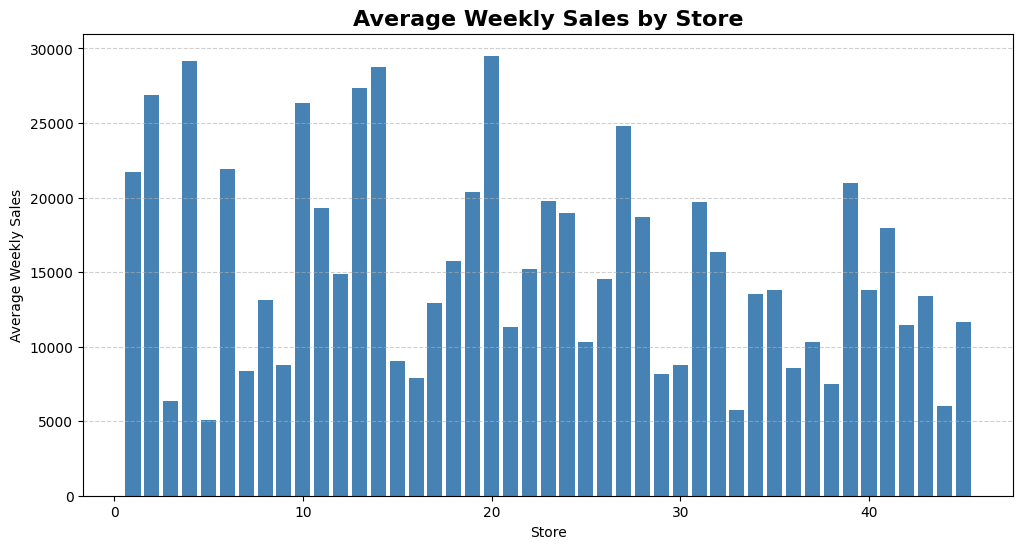

In [19]:
avg_sales = df.groupby("Store")["Weekly_Sales"].mean()

plt.figure(figsize=(12,6))
plt.bar(avg_sales.index, avg_sales.values, color="steelblue")
plt.title("Average Weekly Sales by Store", fontsize=16, fontweight="bold")
plt.xlabel("Store")
plt.ylabel("Average Weekly Sales")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


# **Seasonal Decomposition**

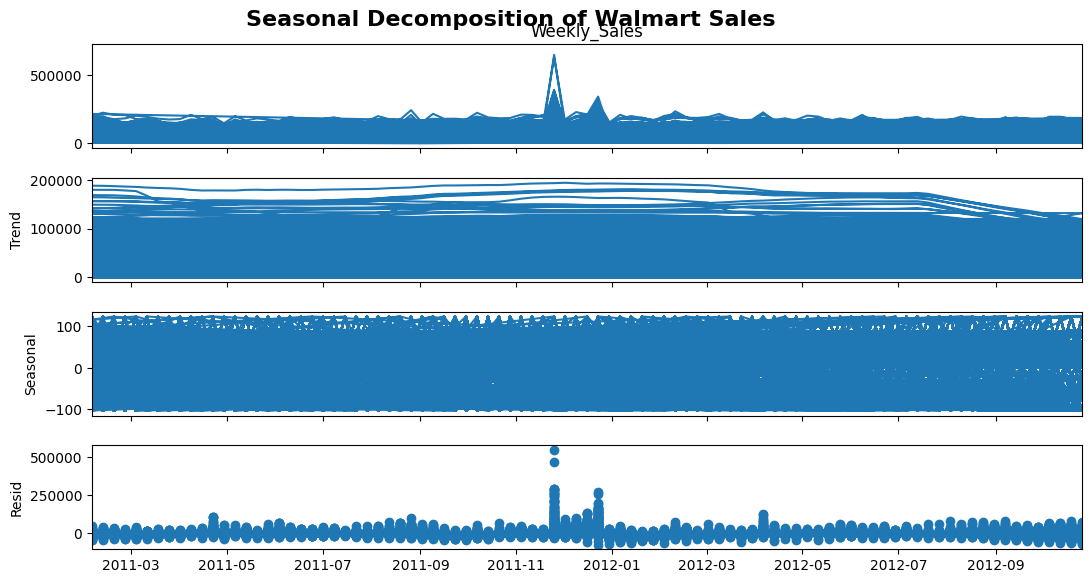

In [20]:
decomp = seasonal_decompose(df_features.set_index("Date")["Weekly_Sales"],
                            model="additive", period=30)

fig = decomp.plot()
fig.set_size_inches(12,6)
plt.suptitle("Seasonal Decomposition of Walmart Sales", fontsize=16, fontweight="bold")
plt.show()


# **Linear Regression Model**

In [21]:
store_id, dept_id = 1, 1
sample = df_features[(df_features.Store==store_id) & (df_features.Dept==dept_id)].copy()

train_df, valid_df = sample.iloc[:-12], sample.iloc[-12:]
feature_cols = [c for c in sample.columns if c not in ["Date","Weekly_Sales","Store","Dept"]]

X_train, y_train = train_df[feature_cols], train_df["Weekly_Sales"]
X_valid, y_valid = valid_df[feature_cols], valid_df["Weekly_Sales"]

lr = LinearRegression().fit(X_train, y_train)
pred_lr = lr.predict(X_valid)

mae = mean_absolute_error(y_valid, pred_lr)
rmse = np.sqrt(mean_squared_error(y_valid, pred_lr))
print(f"Linear Regression → MAE: {mae:.2f}, RMSE: {rmse:.2f}")


Linear Regression → MAE: 1719.61, RMSE: 2098.05


# **XGBoost Model**

In [22]:
xgb = XGBRegressor(n_estimators=600, learning_rate=0.05, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_valid)

mae = mean_absolute_error(y_valid, pred_xgb)
rmse = np.sqrt(mean_squared_error(y_valid, pred_xgb))
print(f"XGBoost → MAE: {mae:.2f}, RMSE: {rmse:.2f}")


XGBoost → MAE: 1216.27, RMSE: 1596.81


# **LightGBM Model**

In [23]:
lgbm = LGBMRegressor(n_estimators=600, learning_rate=0.05, max_depth=7, random_state=42)
lgbm.fit(X_train, y_train)
pred_lgbm = lgbm.predict(X_valid)

mae = mean_absolute_error(y_valid, pred_lgbm)
rmse = np.sqrt(mean_squared_error(y_valid, pred_lgbm))
print(f"LightGBM → MAE: {mae:.2f}, RMSE: {rmse:.2f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 402
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 17
[LightGBM] [Info] Start training from score 22596.330906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

# **Actual vs Predicted Plot**

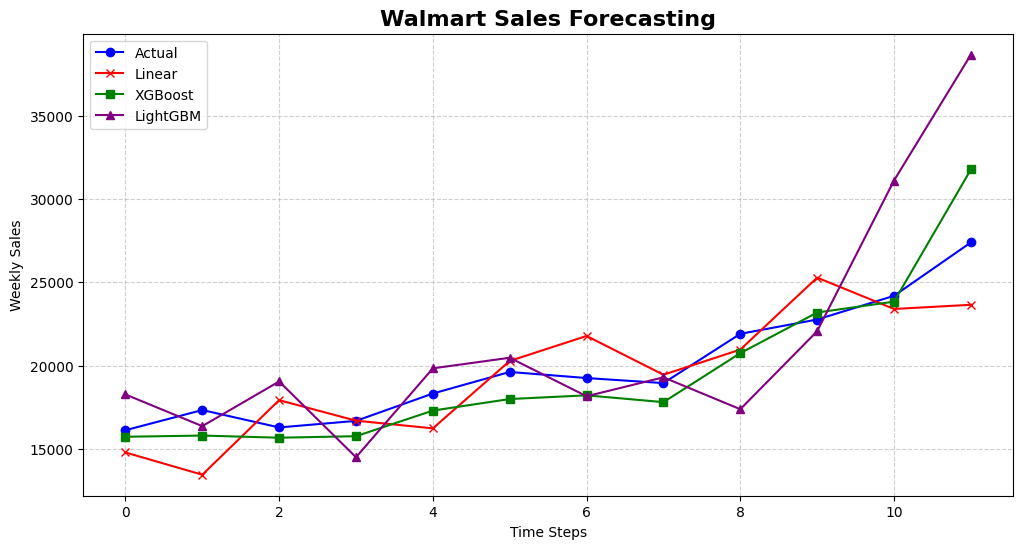

In [24]:
plt.figure(figsize=(12,6))
plt.plot(y_valid.values[:50], label="Actual", color="blue", marker="o")
plt.plot(pred_lr[:50], label="Linear", color="red", marker="x")
plt.plot(pred_xgb[:50], label="XGBoost", color="green", marker="s")
plt.plot(pred_lgbm[:50], label="LightGBM", color="purple", marker="^")

plt.title("Walmart Sales Forecasting", fontsize=16, fontweight="bold")
plt.xlabel("Time Steps")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(linestyle="--", alpha=0.6)
plt.show()


# **Rolling Averages & STL**

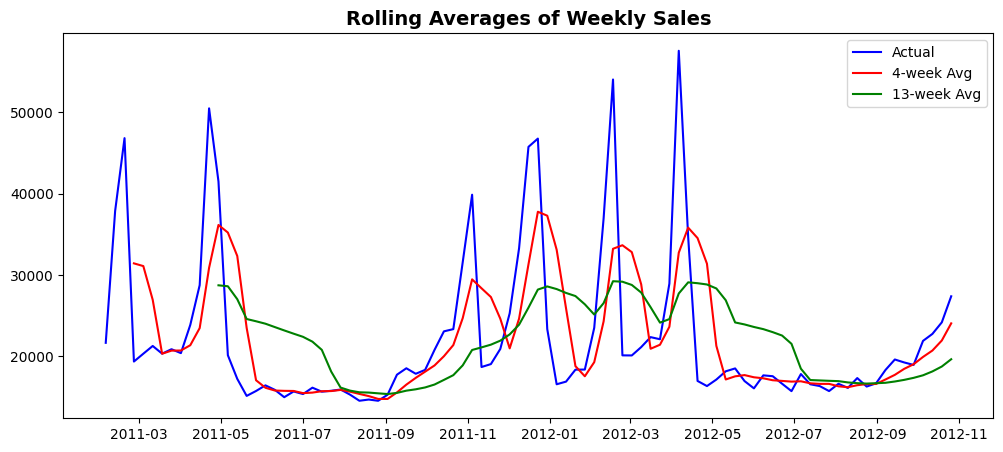

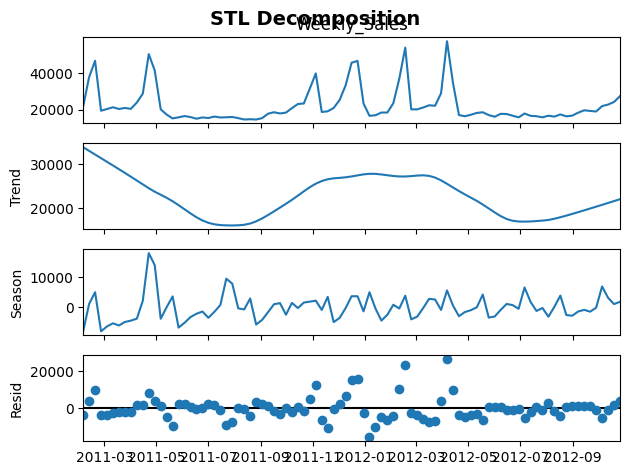

In [25]:
sample_series = sample.set_index("Date")["Weekly_Sales"]

# Rolling averages
plt.figure(figsize=(12,5))
plt.plot(sample_series, label="Actual", color="blue")
plt.plot(sample_series.rolling(4).mean(), label="4-week Avg", color="red")
plt.plot(sample_series.rolling(13).mean(), label="13-week Avg", color="green")
plt.legend()
plt.title("Rolling Averages of Weekly Sales", fontsize=14, fontweight="bold")
plt.show()

# STL decomposition
stl = STL(sample_series, period=13)
res = stl.fit()
res.plot()
plt.suptitle("STL Decomposition", fontsize=14, fontweight="bold")
plt.show()


# **Save & Reload Processed Data**

In [26]:
# Save processed dataset
df_features.to_csv("walmart_sales_processed.csv", index=False)
joblib.dump(df_features, "task7_sales_forecasting.pkl")

print("Data saved successfully!")

# Reload check
df_check = pd.read_csv("walmart_sales_processed.csv")
print(df_check.head())


Data saved successfully!
   Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  2011-02-04      21665.76          0        42.27       2.989   
1      1     1  2011-02-11      37887.17          1        36.39       3.022   
2      1     1  2011-02-18      46845.87          0        57.36       3.045   
3      1     1  2011-02-25      19363.83          0        62.90       3.065   
4      1     1  2011-03-04      20327.61          0        59.58       3.288   

          CPI  Unemployment  Type  ...  Day     lag_1     lag_2     lag_4  \
0  212.566881         7.742     1  ...    4  18461.18  17341.47  15984.24   
1  212.936705         7.742     1  ...   11  21665.76  18461.18  17359.70   
2  213.247885         7.742     1  ...   18  37887.17  21665.76  17341.47   
3  213.535609         7.742     1  ...   25  46845.87  37887.17  18461.18   
4  213.823333         7.742     1  ...    4  19363.83  46845.87  21665.76   

      lag_8    lag_13    lag_26